# Investigate a Dataset - Titanic Dataset

## Introduction
This report is aiming at analyzing the titanic dataset that are provided on [Kaggle](https://www.kaggle.com/c/titanic/data). The analysis will look into a number of features of the passengers to see what are the factors that might be relevant to the survival of passengers.

## Table of Content
There are a number of parts in this report
1. Data Wraggling
2. Correlation Analysis - Analysing correlations between a number of the features from the data as this might have an effect on our conclusions at the end
3. Descriptive Statistics on Survivors
4. Validation on some common understandings
    * Children and elderly are more likely to survived as people tend to take care of them
    * Female are more likely to survived as people tend to let female passengers board the rescue boats first (as illustrated in the Titanic movie)
    * Rich people have a higher surivial rate due to a number of reasons, including priority of boarding rescue boat, bribing the crew and other unknowen reasons
5. Conclusions
6. Appendix

## Data Wraggling
Before doing any analysis, we will first need to import all the necessary python packages and the data

In [1]:
# import all necessary packages and functions.
import csv
import numpy as np
import pandas as pd
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter

# read in the data by pandas
passengers_data = pd.read_csv('titanic-data.csv')
display(passengers_data.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


After taking a glimpse of the data, there are a few fields looks pretty meaningless (i.e. `PassengerId`, `Name`, `Ticket`) in the following analysis, so we will first remove them.

In [2]:
passengers_data.drop('PassengerId', axis=1, inplace=True)
passengers_data.drop('Name', axis=1, inplace=True)
passengers_data.drop('Ticket', axis=1, inplace=True)
display(passengers_data.head())

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


For easier analysis, we would want to setup the `Survived` and `Sex` fields as categorical data. One interesting part is that we will not categorized `Pclass` as we would like to do a correlation analysis for `Pclass` in the next section. We will also make a number of fields (`Pclass`, `Sibsp`, `Parch`) into integer type for a matter of correctness and clarity.

In [3]:
for col in ['Survived', 'Sex']:
    passengers_data[col] = passengers_data[col].astype('category')
    
for col in ['Pclass', 'SibSp', 'Parch']:
    passengers_data[col] = passengers_data[col].astype('int64')

Before we do any investigations, we should also take a look if there are any missing values in the data, so that we make sure we will handle them when doing further analysis.

In [4]:
print("Count on missing values in each of the field:")
display(passengers_data.isnull().sum())

Count on missing values in each of the field:


Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

It seems that the field `Age`, `Cabin` and `Embarked` is having quite some missing values, so we will need to make sure we exclude those values when needed.

Apart from the auditing the data for missing values, we will also want some basic statistics on the dataset to give us more idea of the data.

In [5]:
print "Mean of fields:"
display(passengers_data.mean())

print "Counts of fields:"
display(passengers_data.count())

Mean of fields:


Survived     0.383838
Pclass       2.308642
Age         29.699118
SibSp        0.523008
Parch        0.381594
Fare        32.204208
dtype: float64

Counts of fields:


Survived    891
Pclass      891
Sex         891
Age         714
SibSp       891
Parch       891
Fare        891
Cabin       204
Embarked    889
dtype: int64

From the briefing inspection, there are 891 records in this dataset. Most of the records are from third class cabin. This aligned to the fact that 324 in First Class, 284 in Second Class, and 709 in Third Class, based on historical documentations.

## Correlation Analysis
In this section, we will make use of correlation matrix to see if there are any correlation between features.

In [6]:
passengers_data.corr()

,Pclass,Age,SibSp,Parch,Fare
Pclass,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,-0.549500,0.096067,0.159651,0.216225,1.000000


In general, we will an |correlation| < 0.3 as weak correlation(which we usually consider as no significant correlation). For 0.3 < |correlation| < 0.7, it is considered as moderate correlaton.

From what we found, there seemed to be a moderate correlation between `# of siblings / spouses aboard the Titanic` and `# of parents / children aboard the Titanic` which can be reasonably explained by the case of family trips.

Also, we identified another stronger correlation, which is a negative corrleation between `Ticket class` and `Passenger fare`. This makes a lot of sense, as the higher the class (i.e. smaller the class number), the higher the fare. This finding actually allow us to take only one of the features into considerations in the later analysis regarding social status or personal wealth.

## Descriptive Statistics on Survivors
Just before we conclude this Titanic tregedy analysis, let's also look at some descriptive statistics on the survivors and the victims.

As we are concerned with age and personal of survivors, we will also run a t-test for means of two independent samples for Age and Fare to see if there are signigicant differences between survivors and victims.

In [7]:
from scipy.stats import ttest_ind_from_stats

# filter out passengers by survival
survived = passengers_data[passengers_data['Survived']==1]
dead = passengers_data[passengers_data['Survived']==0]

passengers_data_groupby_survived = passengers_data.groupby('Survived')
means = passengers_data_groupby_survived.mean()
median = passengers_data_groupby_survived.median()
sd = passengers_data_groupby_survived.std()

display(means)
display(median)
display(sd)

print "T-test results for Age:"
print ttest_ind_from_stats(means['Age'][0], sd['Age'][0], len(dead), means['Age'][1], sd['Age'][1], len(survived))

print "T-test results for Fare:"
print ttest_ind_from_stats(means['Fare'][0], sd['Fare'][0], len(dead), means['Fare'][1], sd['Fare'][1], len(survived))

,Pclass,Age,SibSp,Parch,Fare
Survived,,,,,
0,2.531876,30.626179,0.553734,0.329690,22.117887
1,1.950292,28.343690,0.473684,0.464912,48.395408


,Pclass,Age,SibSp,Parch,Fare
Survived,,,,,
0,3,28.0,0,0,10.5
1,2,28.0,0,0,26.0


,Pclass,Age,SibSp,Parch,Fare
Survived,,,,,
0,0.735805,14.172110,1.288399,0.823166,31.388207
1,0.863321,14.950952,0.708688,0.771712,66.596998


T-test results for Age:
Ttest_indResult(statistic=2.2888971769109268, pvalue=0.022319082156674223)
T-test results for Fare:
Ttest_indResult(statistic=-7.9391916608710611, pvalue=6.1201893419238888e-15)


From the t-test result, we can concluded that there are a differences in the average age of the survivors and victims. Apparently the older you are, the less chances that you survived from the incident.

On the other hand, there is a very confident differences (P-value of 6.1201893419238888e-15) between the fare paid by survivors and victims. It seems that the general understanding that "rich people leave first" does have at least some grounds.

While we cannot draw much solid conclusions from these descriptive statistics, this provided some insights on the investigations that we are going to look into in the next sections.

## Validation on some common understandings
In this part, we will look into three famous rumours or guesses people made on the Titanic tragedy.

### Children and elderly are more likely to survived as people tend to take care of them
To investigate on this issue, we will first needed to define `Children` as age < 12 and `Elderly` as age > 60. First, we will look at how many children and elderly are onboard.

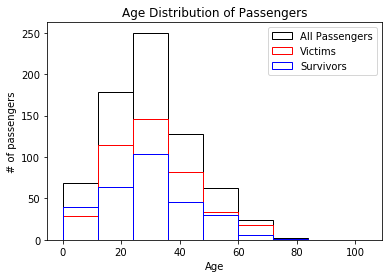

In [8]:
# plotting the age distribution of all, survived and dead passengers on the same graph
# we will also need to use the dropna() function on Age as we previously identified there are missing values in Age
plt.figure(1)
plt.hist(passengers_data.Age.dropna(), bins=[0,12,24,36,48,60,72,84,96,104], edgecolor='black', fill=False, stacked=False, label="All Passengers")
plt.hist(dead.Age.dropna(), bins=[0,12,24,36,48,60,72,84,96,104], edgecolor = "red", stacked=True, fill=False, label="Victims")
plt.hist(survived.Age.dropna(), bins=[0,12,24,36,48,60,72,84,96,104], edgecolor = "blue", stacked=True, fill=False, label="Survivors")

# adding labels
plt.title('Age Distribution of Passengers')
plt.legend()
plt.xlabel('Age')
plt.ylabel('# of passengers')

From the histogram, we can see that among all ages groups except children with age under 12, are having a lower survival rate than death rate (indicated by a higher blue line than red line). So the myth that both children and elderly are having a higher survival rate is only partially correct.

By assuming that people does give priority to leave Titanic for children and elderly, we can attribute the low surivial rate of elderly by bad health conditions and less likely to withstand the extreme body requirements to survive in the freezing weather.

### Female are more likely to survived as people tend to let female passengers board the rescue boats first (as illustrated in the Titanic movie)

To investigate this issue, we can do a similar analysis as the previous rumour, except we are plotting the geneder distribution instead

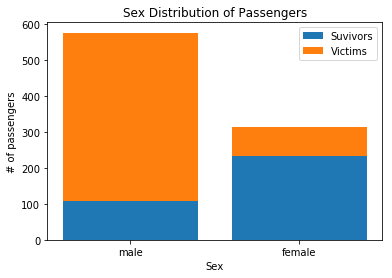

In [9]:
# plotting the gender distribution of survived and dead passengers on the same graph
plt.figure(2)

# for survived passengers
survived_counts = Counter(survived.Sex)
survived_frequencies = survived_counts.values()
x_labels = survived_counts.keys()
bar_x_locations = np.arange(len(survived_frequencies))
plt.bar(bar_x_locations, survived_frequencies, align = 'center', label='Suvivors')

# for dead passengers
dead_counts = Counter(dead.Sex)
dead_frequencies = dead_counts.values()
plt.bar(bar_x_locations, dead_frequencies, bottom=survived_frequencies, align = 'center', label='Victims')

# adding labels
plt.xticks(bar_x_locations, x_labels)
plt.title('Sex Distribution of Passengers')
plt.legend()
plt.xlabel('Sex')
plt.ylabel('# of passengers')

Obviously, female is having a much higher percentage of survival comparing to male, as shown in the figure. To have a more concrete comparison, we will be calculating the actual survival rate as below:

In [10]:
counts = Counter(passengers_data.Sex)
survival_counts = Counter(survived.Sex)

male_survival_rate = float(survival_counts['male'])/counts['male']
female_survival_rate = float(survival_counts['female'])/counts['female']

print 'Male Survival Rate: {:.1%}'.format(male_survival_rate)
print 'Female Survival Rate: {:.1%}'.format(female_survival_rate)

Male Survival Rate: 18.9%
Female Survival Rate: 74.2%


Putting our findings in a numerical way, female is having a 74.2% of survival rate while male got a survival rate of 18.9% only. While we cannot conclude if this is really due to the female priority for rescue boat, but at least we can be sure that there was a correlation between gender and survival in the Titanic incident.

### Rich people have a higher surivial rate due to a number of reasons

A common perception is that rich people are more likely to survive due a various reason, including priority to rescue ship, bribing the crew etc. This were also a few scenes shown in the classic Titanic movie focusing on the faireness between rich and poor people.

To confirm this, we will do analysis based on the `Ticket class` and `fare`. Firstly, we will calculate the survival rate of different class.

Class 1 Survival Rate: 63.0%
Class 2 Survival Rate: 47.3%
Class 3 Survival Rate: 24.2%


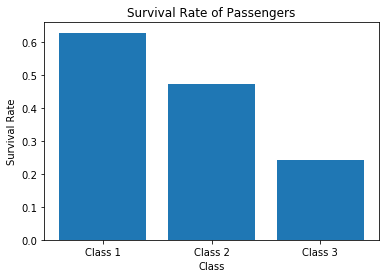

In [11]:
class_counts = Counter(passengers_data.Pclass)
class_survival_counts = Counter(survived.Pclass)

class1_survival_rate = float(class_survival_counts[1])/class_counts[1]
class2_survival_rate = float(class_survival_counts[2])/class_counts[2]
class3_survival_rate = float(class_survival_counts[3])/class_counts[3]

# print class1_survival_rate
print 'Class 1 Survival Rate: {:.1%}'.format(class1_survival_rate)
print 'Class 2 Survival Rate: {:.1%}'.format(class2_survival_rate)
print 'Class 3 Survival Rate: {:.1%}'.format(class3_survival_rate)

plt.figure(3)
frequencies = [class1_survival_rate, class2_survival_rate, class3_survival_rate]
x_labels = ['Class 1', 'Class 2', 'Class 3']
bar_x_locations = np.arange(len(frequencies))
plt.bar(bar_x_locations, frequencies, align = 'center')

# add labels
plt.xticks(bar_x_locations, x_labels)
plt.title('Survival Rate of Passengers')
plt.xlabel('Class')
plt.ylabel('Survival Rate')

While we have concluded that `Ticket Class` and `Fare` are correlated and we might be able to consider only one of them in the following analysis, we can still plot a histogram for the distribution of class for survivals and fatals.

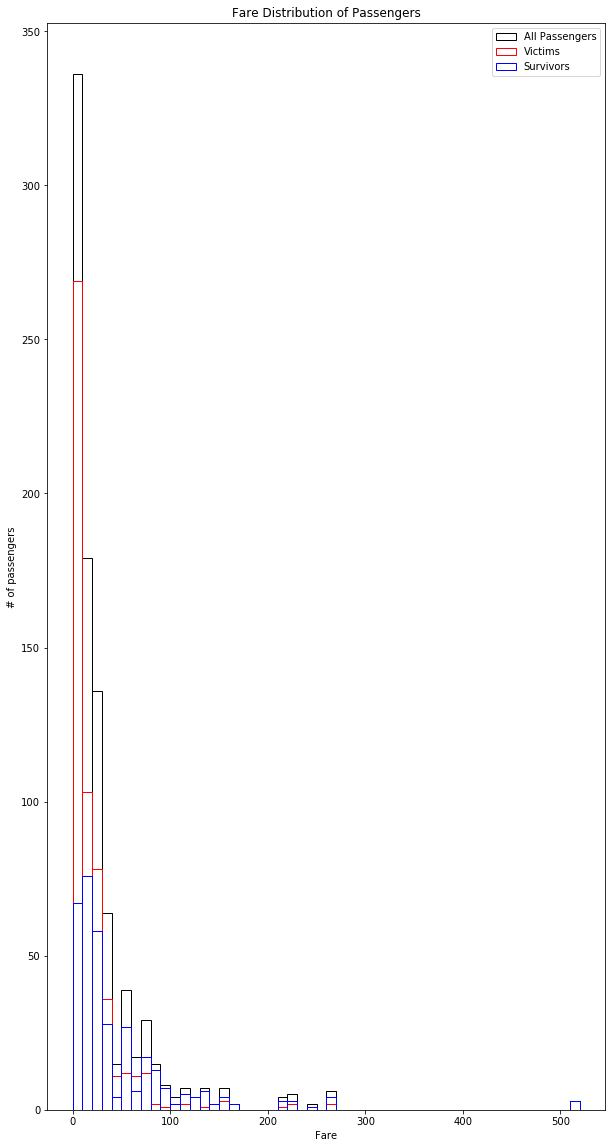

In [12]:
# plotting the class distribution of survived and dead passengers on the same graph
plt.figure(4, figsize=(10,20))
bins = np.arange(min(passengers_data.Fare), max(passengers_data.Fare)+ 10, 10)
plt.hist(passengers_data.Fare, bins=bins, edgecolor='black', fill=False, stacked=False, label='All Passengers')
plt.hist(dead.Fare, bins=bins, edgecolor = "red", stacked=True, fill=False, label='Victims')
plt.hist(survived.Fare, bins=bins, edgecolor = "blue", stacked=True, fill=False, label='Survivors')

# add labels
plt.title('Fare Distribution of Passengers')
plt.legend()
plt.xlabel('Fare')
plt.ylabel('# of passengers')

From this visualization, we can easily identified that for lowest price groups(0-50), the red line is almost doubling the height of blue line, indicating that the death rate is almost doubling the survival rate. Interestingly, you don't need to pay a lot to signiifcantly increase your survival rate, as long as you are paying more that 50 dollars, you are already enjoying the benefit of paying more, in terms of survival rate.

## Conclusions
### Analysis Findings
In this report, we have looked into a number of assumptions people in general made on the survivors of Titanic tragedy. We did confirmed some of the myth but some are apparently ungrounded.

Children do have a higher survivor rate but elderly does not. While we cannot conclude if elderly are being priorited in the evacuation simply from this dataset, we might also need to consider the weaker healthy conditions of elderly. Even they are evacuated first, they might not be able to survived the extreme cold weather in the middle of the sea.

Gender is another important predictor of survival in the accident. Female have a almost 4 times the survival rate compared to male. It can be reasonably concluded that females are also evacuated first but another contributing factors like females are more likely to be taken care of given the historic background and social structure. One good example of this is illustrated by the scene in the Titanic movie that Jack allowed Rose to stay out of the freezing water by staying on top of a wooden furniture but staying in the water himself.

The most controversial factor would be personal wealth and social status, projects by the fare and ticket classes of passengers. While no one want to believe that welathier personnel are more likely to survived in tregedies and accidents, this is indeed the case in the Titanic tragedy. Although we cannot make any conclusions on why rich people is more likely to survive, we do see as long as you are paying enough($50), you are out of the group with death rate doubling survival rate.

To conclude, we are not able to draw a lot of causual conclusions on survival in shipwreck, I believe that these findings combining with historic and scientific analsis would provide useful insights on shipwreck rescue and evacuation protocols.

### Further Research Suggestions
This dataset only covered 891 passengers onboarded to Titanic. However, if we are looking into historical data on Titanic, there were 2,344 people onboarded including all staff, performer and crew. Also there weere approximately 1,317 passengers. That mean we are only have half or even less information from the people on the boat. While we have no idea if these data are skewed to a particular class of people, or physical location on Titanic or other factors, our analysis might be flawed.

Apparently, we also have no clue on the survival of the crew, and those might provide us important insights on the survival of shipwrech. One example might be, sailing knowledge have no effect on survival at all. Another assumption would be crews are having a extremely high death rate as they are staying until last.

To further investigate on this Titanic dataset, I would suggest to look into the rescue procudures, also trying to find out crew information, and compare with historical data to see if there are any bias on this dataset. The escape route of the cabin is another thing worth looking into, as a easier escape route or being close to rescue boat does have a huge effect of survival. If possible, it would also be beneficial for us to try to gather the missing records of other passengers and crew.

## Appendix
As suggested by a Udacity reviewer, maybe a 2D scatter plot showing the relationship of survival and the interaction of features. Here, I will be plotting 3 scatter plot, showing the interaction of `Age & Fare`, `Age & Sex` and `Fare & Sex` to see if there are any interesting findings.

([<matplotlib.axis.YTick at 0x118167ed0>,
 <a list of 2 Text yticklabel objects>)

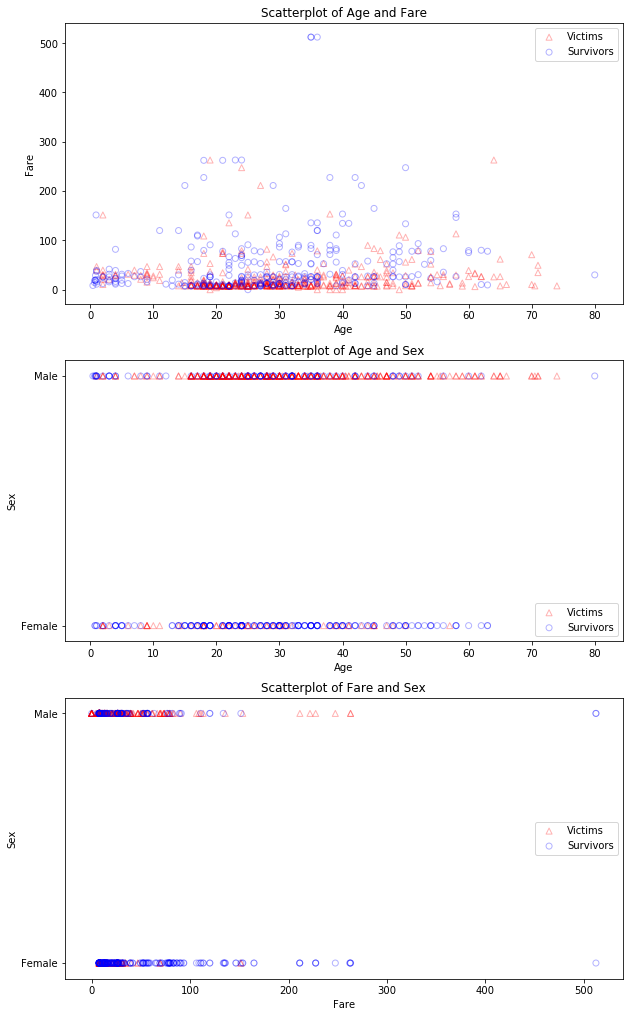

In [13]:
plt.figure(5, figsize=(10,30))
plt.subplot(511)
plt.scatter(dead.Age, dead.Fare, marker='^', facecolors='none', edgecolors='r', alpha=0.3, label='Victims')
plt.scatter(survived.Age, survived.Fare, facecolors='none', edgecolors='b', alpha=0.3, label='Survivors')
# add labels
plt.title('Scatterplot of Age and Fare')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Fare')

# convert sex into number for scatter plot
survived_sex = survived.Sex.map(lambda s: 0 if s == 'female' else 1)
dead_sex = dead.Sex.map(lambda s: 0 if s == 'female' else 1)

plt.subplot(512)
plt.scatter(dead.Age, dead_sex, marker='^', facecolors='none', edgecolors='r', alpha=0.3, label='Victims')
plt.scatter(survived.Age, survived_sex, facecolors='none', edgecolors='b', alpha=0.3, label='Survivors')
# add labels
plt.title('Scatterplot of Age and Sex')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Sex')
bar_y_locations = np.arange(2)
bar_y_labels = ['Female', 'Male']
plt.yticks(bar_y_locations, bar_y_labels)

plt.subplot(513)
plt.scatter(dead.Fare, dead_sex, color='r', marker='^', facecolors='none', edgecolors='r', alpha=0.3, label='Victims')
plt.scatter(survived.Fare, survived_sex, facecolors='none', edgecolors='b', alpha=0.3, label='Survivors')
# add labels
plt.title('Scatterplot of Fare and Sex')
plt.legend()
plt.xlabel('Fare')
plt.ylabel('Sex')
plt.yticks(bar_y_locations, bar_y_labels)

Looking at the first graph showing the relationship between `Age` and `Fare`, there are nothing much interesting.

However, if we are looking into the interaction between `Sex` and `Age`, we will find that boys under 12 are having a high survival rate, no less to girls under 12. In other words, that means the factor of being a children outweigh the effect of being male. This is quite reasonble and we general believe that both boys and girls are enjoying the priority of boarding rescue boats.

For the last graph showing the interaction between `Sex` and `Fare`, we can see that even a wealthy man who pay more than 200 as fare did not really raise their survival rate. While we have no idea on why that happened, but we can somehow concluded that the effect of `Sex` outweigh the effect of `Fare`.

As an appendix, there are not much numerical analysis on the interaction between factors but from the three graphs that we plotted, we can briefly come up with an insight that the effect of `Age` > `Sex` > `Fare`. However, this will require more quantitive analysis to validate this assumption. One more thing to note is that, this power sequence actually match with the usual rescue/evacuation priority - Children/Elderly/Sick > Female > Male.